# Loading Dependencies

In [1]:
from numpy import array
import numpy as np
from scipy.io import loadmat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

from math import sqrt
from numpy import array
from numpy import mean
from sklearn.metrics import mean_squared_error

from pandas import DataFrame
from pandas import concat

(125001, 1)
(125001, 1)
(125001, 1)


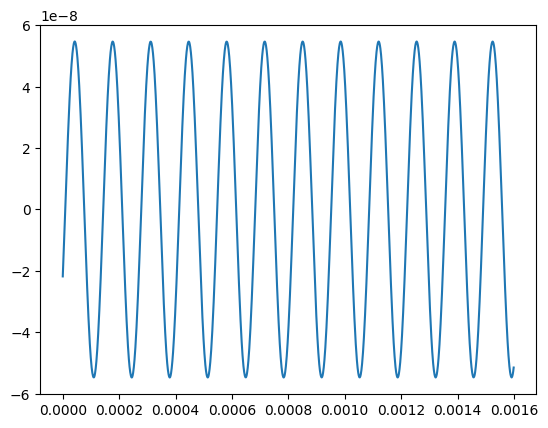

In [12]:
rec_time = 0.1
#rec_time = 60
sampling_rate = 1250000
start_time = 0
t_array = np.arange(start_time, rec_time, 1/sampling_rate)
t_array = np.array(t_array)
t_array = t_array[:,np.newaxis]

velocity_dataset = loadmat("datasel_7422Hz_Sin_800mSrec_4-40kHzfilter_0.449mA_pointfromtip_2.mat")
velocity_raw  = velocity_dataset["datasel"]
velocity = velocity_raw[:, 1]
velocity = np.array(velocity)
velocity = velocity[:,np.newaxis]


#displacement = simpson(velocity, t_array)
def calculate_displacement(velocity, sampling_rate):
    displacement_initial = []
    for i in range(len(velocity)):
        displacement = velocity[i] * (1/sampling_rate)
        displacement_initial = np.append(displacement_initial, displacement)
    
    return displacement_initial

displacement_initial = calculate_displacement(velocity, sampling_rate)

displacement = np.array(displacement_initial)
displacement = displacement[:,np.newaxis]

print(displacement.shape)
print(velocity.shape)
print(t_array.shape) 

#plt.plot(velocity)
plt.plot(t_array[:2000, 0], displacement[:2000, 0])

# Loading the dataset

In [18]:
# For voltage data
# data_file =loadmat("10filtered_700_13000.mat") 
# x_rec = data_file["low_filtered"]
# print(x_rec[1:5, 0])
# print(x_rec.shape)

# For displacement data from LASER
# data_file =loadmat("integrated displacement sine.mat") 
x_rec = displacement
#print(x_rec[1:5, 0])
print(x_rec.shape)

(125001, 1)


# Univariate dataset preparation : from timeseries to supervised learning

In [19]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [33]:
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(x_rec[40000:42004, 0], n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape)
print(y.shape)

(2001, 3, 1)
(2001,)


# Loading the test_set for model evaluation

In [34]:
n_features = 1
# validation set 100k-112k
X_test, y_test = split_sequence(x_rec[112000:113004, 0], n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_test.shape)
print(y_test.shape)

(1001, 3, 1)
(1001,)


# Defining the model

In [35]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences= True, input_shape=(n_steps, n_features)))
model.add(LSTM(150, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X, y, epochs=2000, validation_data=(X_test, y_test), verbose=0)
model.save('LSTM_sine_final.hdf5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 150)            91200     
                                                                 
 lstm_5 (LSTM)               (None, 150)               180600    
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 271,951
Trainable params: 271,951
Non-trainable params: 0
_________________________________________________________________


In [30]:
# demonstrate prediction
#input = X_test
input = X
prediction_list = []
for row in input:
    x_input = array(row)
    x_input = x_input.reshape((1, n_steps, n_features))
    
    # making predictions
    yhat = model.predict(x_input, verbose=0)
    prediction_list.append(yhat)


predicted_values = np.array(prediction_list)


KeyboardInterrupt: 

# Plot History

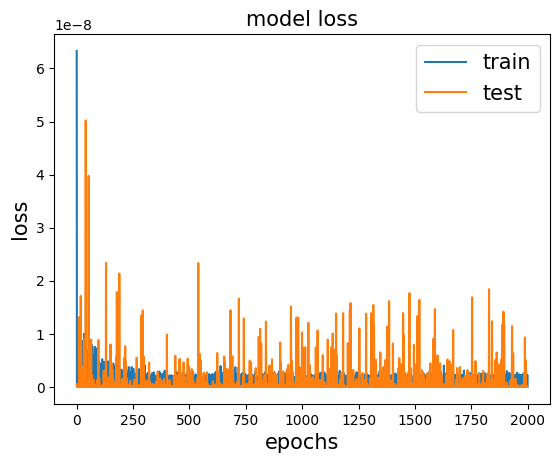

(2000, 1, 1)


In [31]:
# plot history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
#pyplot.legend()

pyplot.title('model loss',size=15)
pyplot.ylabel('loss',size=15)
pyplot.xlabel('epochs',size=15)
pyplot.legend(loc='upper right',fontsize=15)

pyplot.show()
print(predicted_values.shape)

# Training and Model evaluation

In [32]:
R2_score_train = r2_score(y, predicted_values[:, 0])
R2_score_train = "{:.4f}".format(R2_score_train)
print(f"The observed R2_score for the voltage training_set is:",R2_score_train)


# R2_score_test = r2_score(X_test[4:, 0], predicted_values[0:-4, 0], force_finite=False)
# R2_score_test = "{:.4f}".format(R2_score_test)
# print(f"The observed R2_score for the test_set is:",R2_score_test)

The observed R2_score for the voltage training_set is: -7245.8812


(10000, 1, 1)


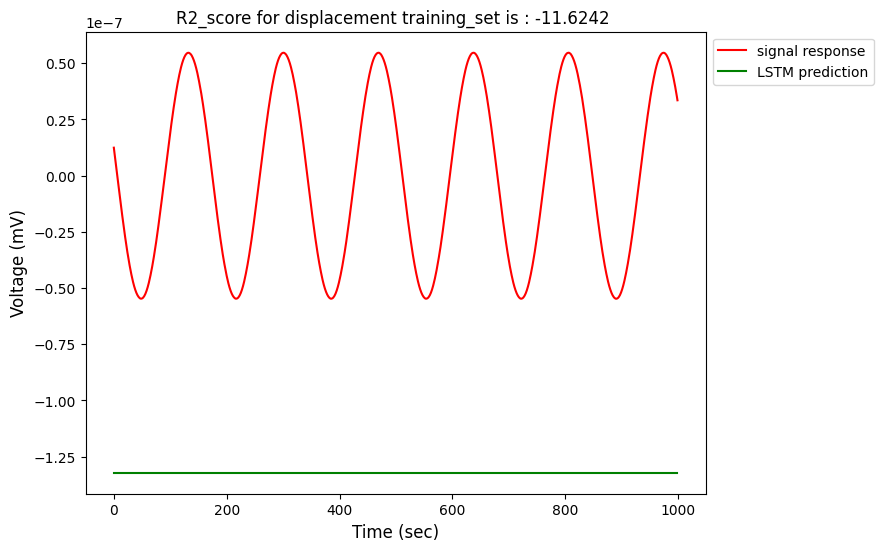

In [11]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.set_ylabel('Voltage (mV)', fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
print(predicted_values.shape)

#For training set
plt.plot (X[4:1004, 0], 'r', label="signal response")
plt.plot(predicted_values[0:1000, 0], 'g', label= "LSTM prediction")

# For Laser data 
ax.set_title(f'R2_score for displacement training_set is : {R2_score_train} ')

# # For voltage data
# ax.set_title(f'R2_score for voltage training_set with LSTM is : {R2_score_train}')
 
#For test_set
# plt.plot (X_test[4:1004, 0], 'r', label="signal response")
# plt.plot(predicted_values[0:1000, 0], 'g', label= "LSTM prediction")

# # For Laser data 
# ax.set_title(f'R2_score for displacement validation set with LSTM is : {R2_score_test} ')

#For voltage data
# ax.set_title(f'R2_score for voltage test_set with LSTM is : {R2_score_test}')

ax.legend(loc='upper left', bbox_to_anchor=(1.0005, 1))

# Perform GridSearch for Hyperparameter tuning!

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes[0], activation='relu', return_sequences= True, input_shape=(n_input, n_features)))
	model.add(LSTM(n_nodes[1], activation='relu'))
	model.add(Dense(1))
	model.compile(optimizer='adam', loss='mse')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.4f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=3):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.4f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [3]
	n_nodes = [(50, 50), (100, 50), (50, 100),(100, 100)]
	n_epochs = [500]
	n_batch = [32]
	n_diff = [0]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# define dataset
data = x_rec[40000:51000, 0]
# data split
n_test = 1000
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 4
 > 0.0003
 > 0.0004
 > 0.0003
> Model[[3, (50, 50), 500, 32, 0]] 0.0003


: 

: 